# Summary
In this notebook we load the china data and organize it in a way that allow for training.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm

# mac path
os.chdir('../../') #set path on /root/{downstream,upstream,combined}
os.getcwd()


'/Users/davidharar/Documents/School/thesis/git_repositories'

In [31]:
def plot_temp(segment):
    fig, axs = plt.subplots(6, 2, figsize=(12, 18))
    for i in range(12):
        ax = axs[i // 2, i % 2]
        ax.plot(segment[i])
        ax.set_title(f'Signal {i+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')

    # Adjust layout
    plt.tight_layout()
    plt.show()


def load_one_example(filename, data_path):
    mat_filename = data_path+filename+'.mat'
    hea_filename = data_path+filename+'.hea'
    x = loadmat(mat_filename)
    data = np.asarray(x['val'], dtype=np.float64)
    with open(hea_filename,'r') as f:
        header_data=f.readlines()
    diagnose = [x for x in header_data if '#Dx' in x]
    diagnose = [x.replace('#Dx:','').strip() for x in diagnose]

    return data, diagnose

# Load

## one example

In [2]:
data_path = "./downstream_classification/data/china-raw/"
filename = 'Q0001'
mat_filename = data_path+filename+'.mat'
hea_filename = data_path+filename+'.hea'
x = loadmat(mat_filename)
data = np.asarray(x['val'], dtype=np.float64)
with open(hea_filename,'r') as f:
    header_data=f.readlines()
data, header_data

(array([[  0.,   0.,   0., ..., -13.,  -8., -10.],
        [ 10.,  12.,  11., ...,  -1.,   4.,   7.],
        [ 10.,  13.,  12., ...,  12.,  12.,  18.],
        ...,
        [ 75., 103.,  89., ..., 107., 104., 121.],
        [ 16.,  18.,  13., ...,   2.,   6.,   8.],
        [  9.,   9.,   4., ...,   3.,   2.,   3.]]),
 ['Q0001 12 500 5000 15-May-2020 15:35:30\n',
  'Q0001.mat 16+24 1000/mV 16 0 0 -14 0 I\n',
  'Q0001.mat 16+24 1000/mV 16 0 10 -9 0 II\n',
  'Q0001.mat 16+24 1000/mV 16 0 10 -2 0 III\n',
  'Q0001.mat 16+24 1000/mV 16 0 -5 5 0 aVR\n',
  'Q0001.mat 16+24 1000/mV 16 0 -5 21 0 aVL\n',
  'Q0001.mat 16+24 1000/mV 16 0 11 -34 0 aVF\n',
  'Q0001.mat 16+24 1000/mV 16 0 52 -30 0 V1\n',
  'Q0001.mat 16+24 1000/mV 16 0 44 -15 0 V2\n',
  'Q0001.mat 16+24 1000/mV 16 0 17 -39 0 V3\n',
  'Q0001.mat 16+24 1000/mV 16 0 75 -64 0 V4\n',
  'Q0001.mat 16+24 1000/mV 16 0 16 -27 0 V5\n',
  'Q0001.mat 16+24 1000/mV 16 0 9 18 0 V6\n',
  '#Age: 53\n',
  '#Sex: Male\n',
  '#Dx: 164867002,427084000\

## Automate

In [3]:
snomed_mapping = pd.read_csv('./downstream_classification/data/SNOMED_mappings/SNOMED_mappings_scored.csv', sep=';')
snomed_mapping[snomed_mapping['Dx'].str.contains('atrial')]

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
12,premature atrial contraction,284470004,PAC,616,73,3,0,398,639,1729,We score 284470004 and 63593006 as the same di...


In [4]:
snomed_mapping = pd.read_csv('./downstream_classification/data/SNOMED_mappings/SNOMED_mappings_unscored.csv', sep=';')
snomed_mapping[snomed_mapping['Dx'].str.contains('atrial f')]

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total
8,atrial fibrillation and flutter,195080001,AFAFL,0,39,0,0,0,2,41
18,chronic atrial fibrillation,426749004,CAF,0,1,0,0,0,0,1
51,paroxysmal atrial fibrillation,282825002,PAF,0,0,1,1,0,0,2
55,rapid atrial fibrillation,314208002,RAF,0,0,0,2,0,0,2


In [5]:
def load_one_example(filename, data_path):
    mat_filename = data_path+filename+'.mat'
    hea_filename = data_path+filename+'.hea'
    x = loadmat(mat_filename)
    data = np.asarray(x['val'], dtype=np.float64)
    with open(hea_filename,'r') as f:
        header_data=f.readlines()
    diagnose = [x for x in header_data if '#Dx' in x]
    diagnose = [x.replace('#Dx:','').strip() for x in diagnose]

    return data, diagnose


samples = list({f.replace('.hea','').replace('.mat','') for f in os.listdir(data_path)})
Xs = []
labels = []
for j,sample in enumerate(samples):
    X, label = load_one_example(sample, data_path)
    Xs.append(X)
    labels.append(label)
    # print(f'{j}:{load_one_example(sample, data_path)[1]}')
    
AF = []
for label in labels:
    ans = 1 if '164889003' in label[0].split(',') else 0
    AF.append(ans)
AF = pd.Series(AF)
display(AF.value_counts())
display(AF.value_counts(normalize=True))

0    3300
1     153
Name: count, dtype: int64

0    0.955691
1    0.044309
Name: proportion, dtype: float64

# Resample

In [6]:
X = Xs[0]
X = np.expand_dims(X,0)
X.shape

(1, 12, 28791)

(12, 450)


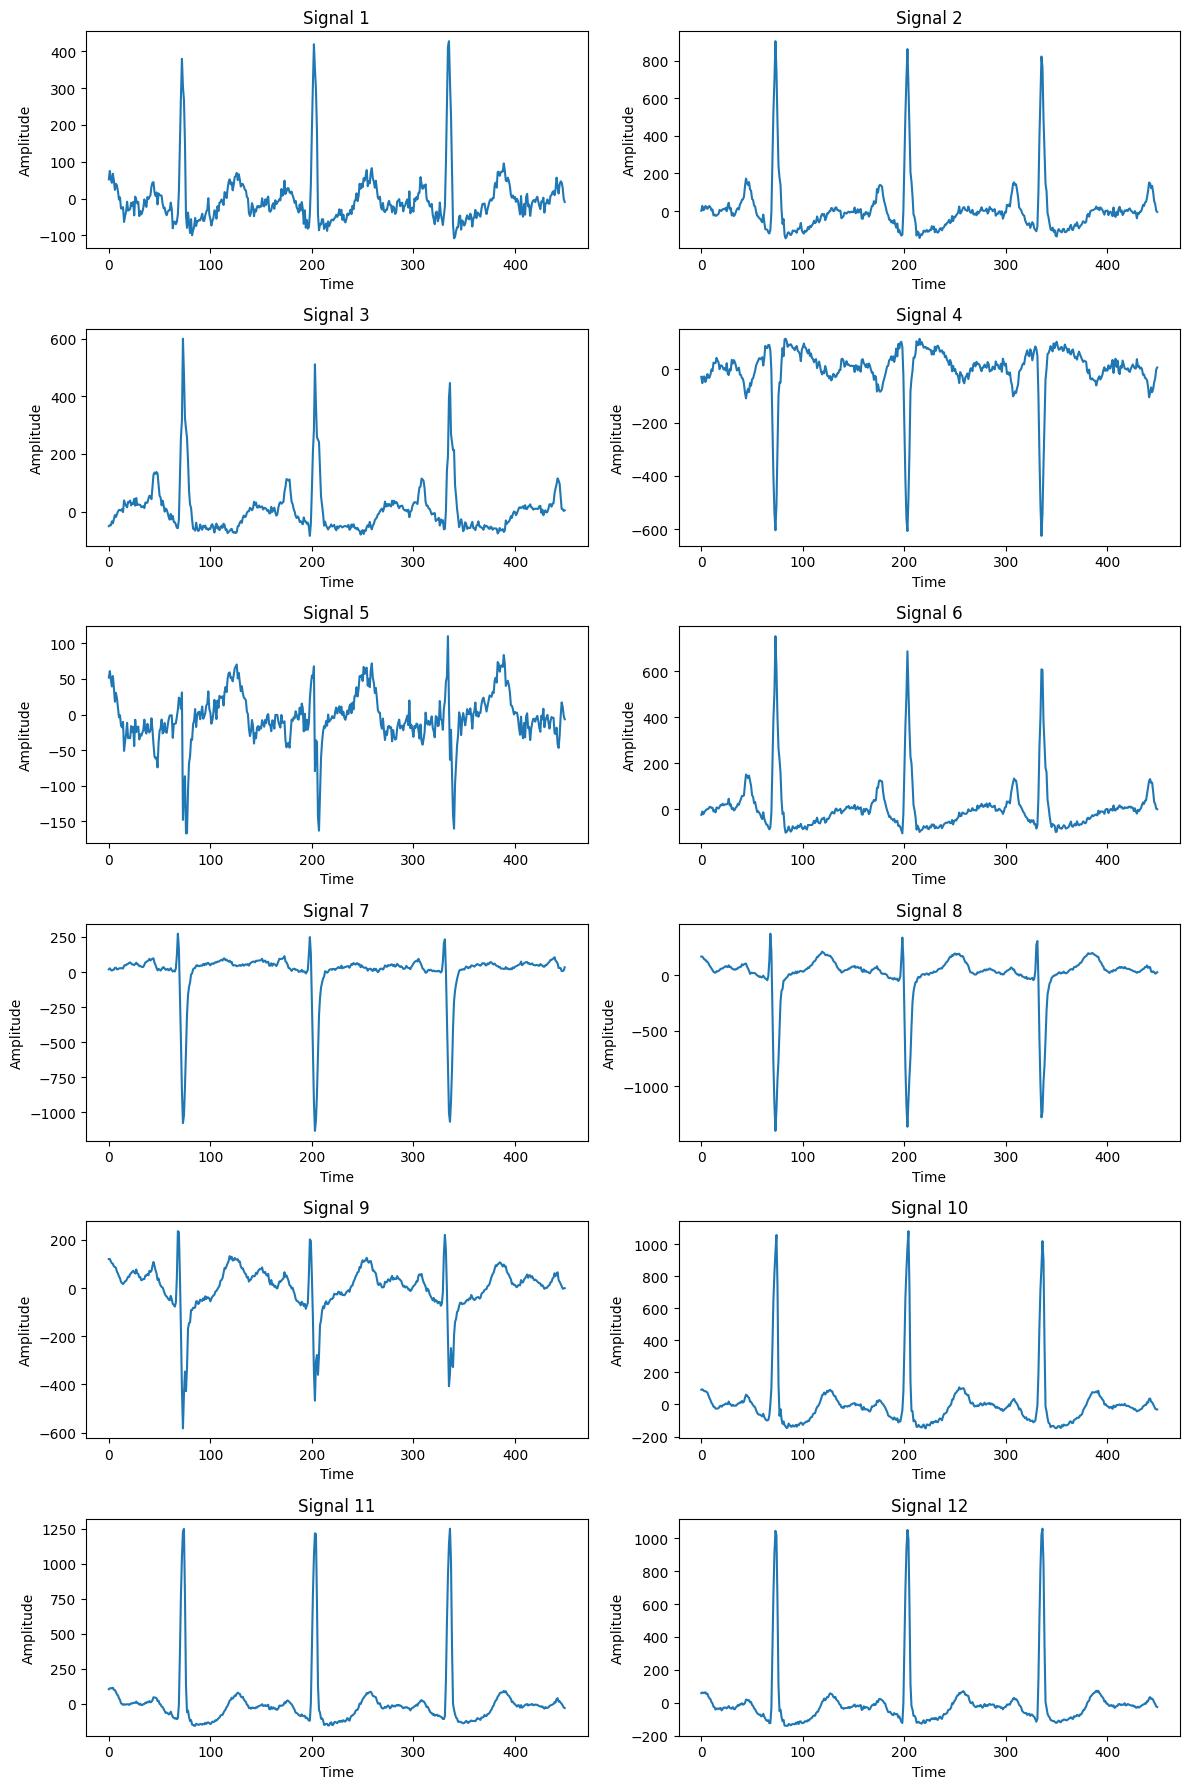

In [7]:
from upstream_seq2seq.utils.signal_processing import resample, normalize
import matplotlib.pyplot as plt

X_resampled = resample(X, original_hz=500, desired_hz=200)
X_resampled.shape

window = 450
start = np.random.randint(0,X_resampled.shape[-1]-window)

X_windowed_resampled = X_resampled[:,:,start:(start+window)]
X_windowed_resampled = np.squeeze(X_windowed_resampled)

print(X_windowed_resampled.shape)

fig, axs = plt.subplots(6, 2, figsize=(12, 18))
for i in range(12):
    ax = axs[i // 2, i % 2]
    ax.plot(X_windowed_resampled[i])
    ax.set_title(f'Signal {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

# Adjust layout
plt.tight_layout()
plt.show()



# Saving
The plan is the following:
1. Load signal (X \in (12,5000), label \in {str})\
2. Process label, convert into binary
3. Process X:
    - Resample X
    - Convolve over X, window of 450, 100 points jump
    - Save in npy files
    - Keep names
4. Create a metadata with columns:
    - label
    - path to file
    - sample
    - original reading index



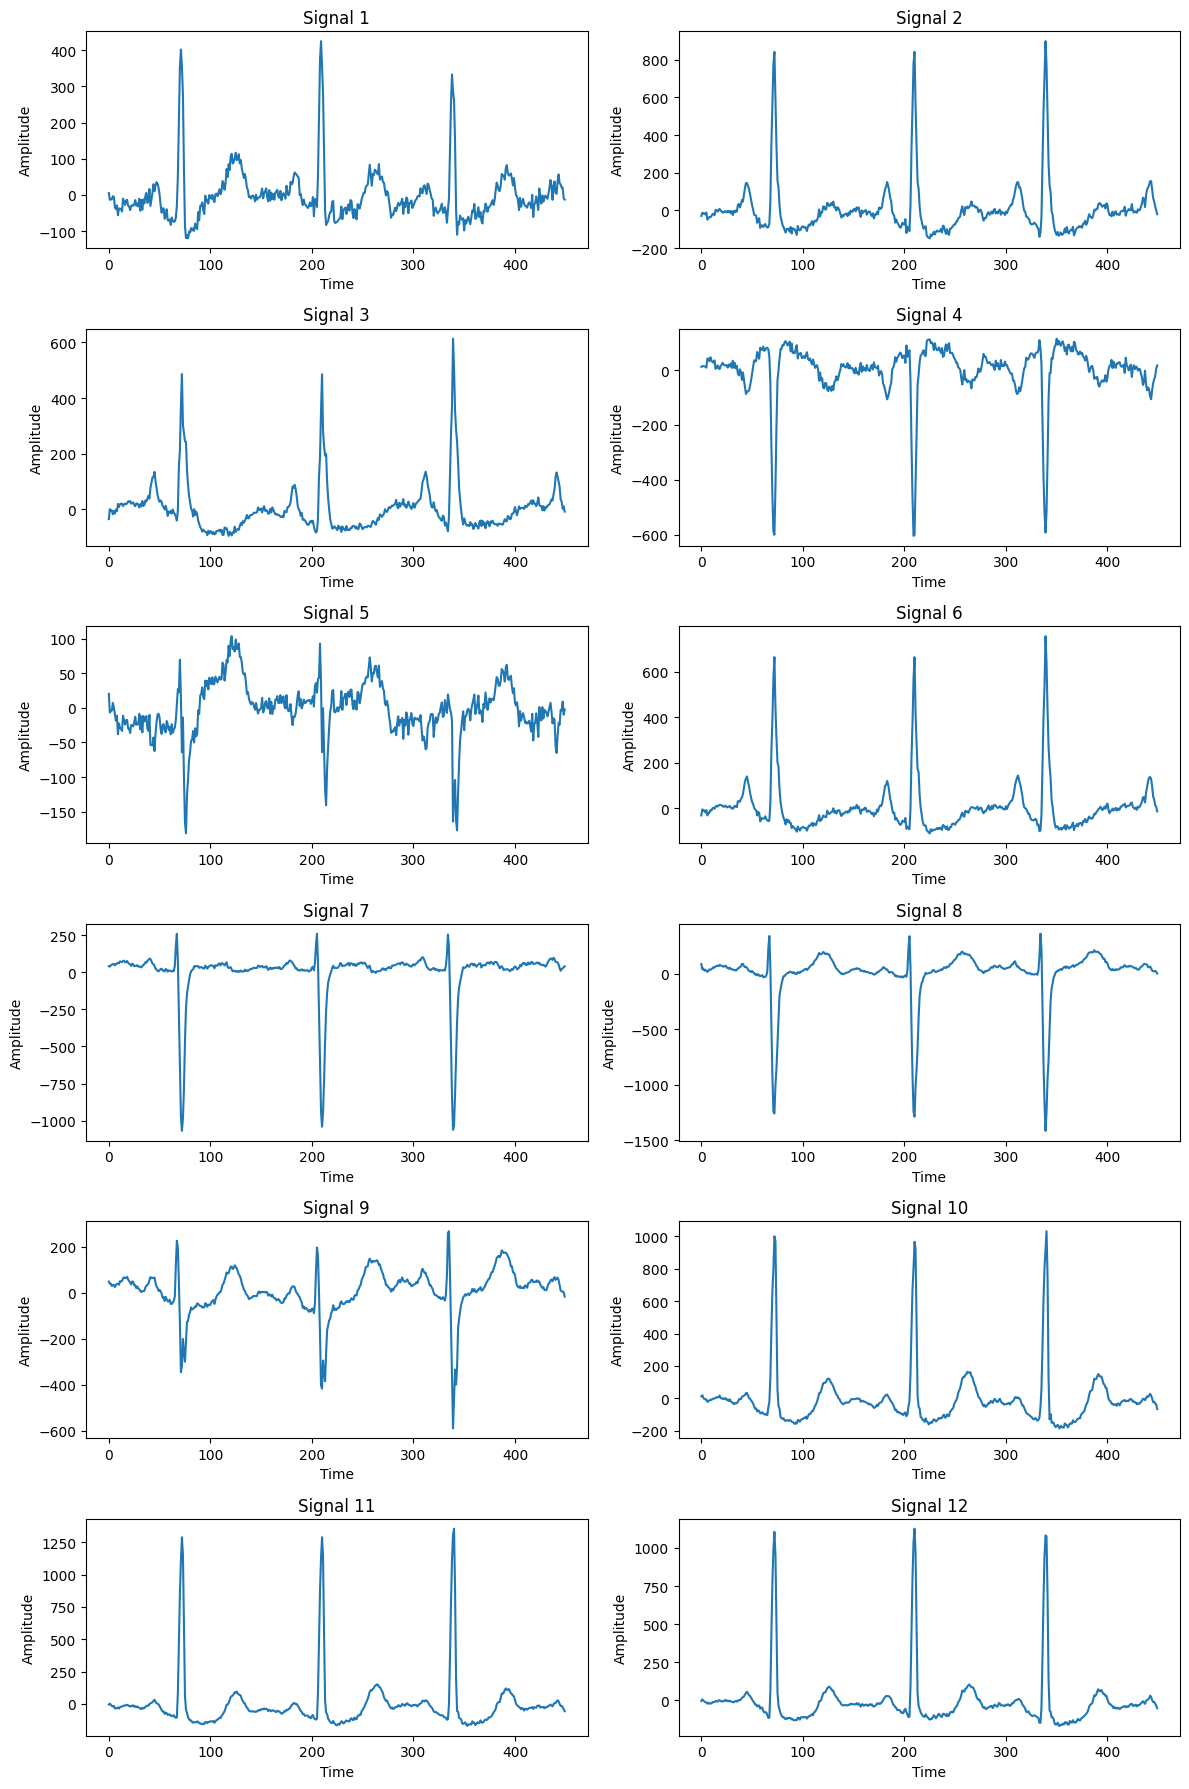

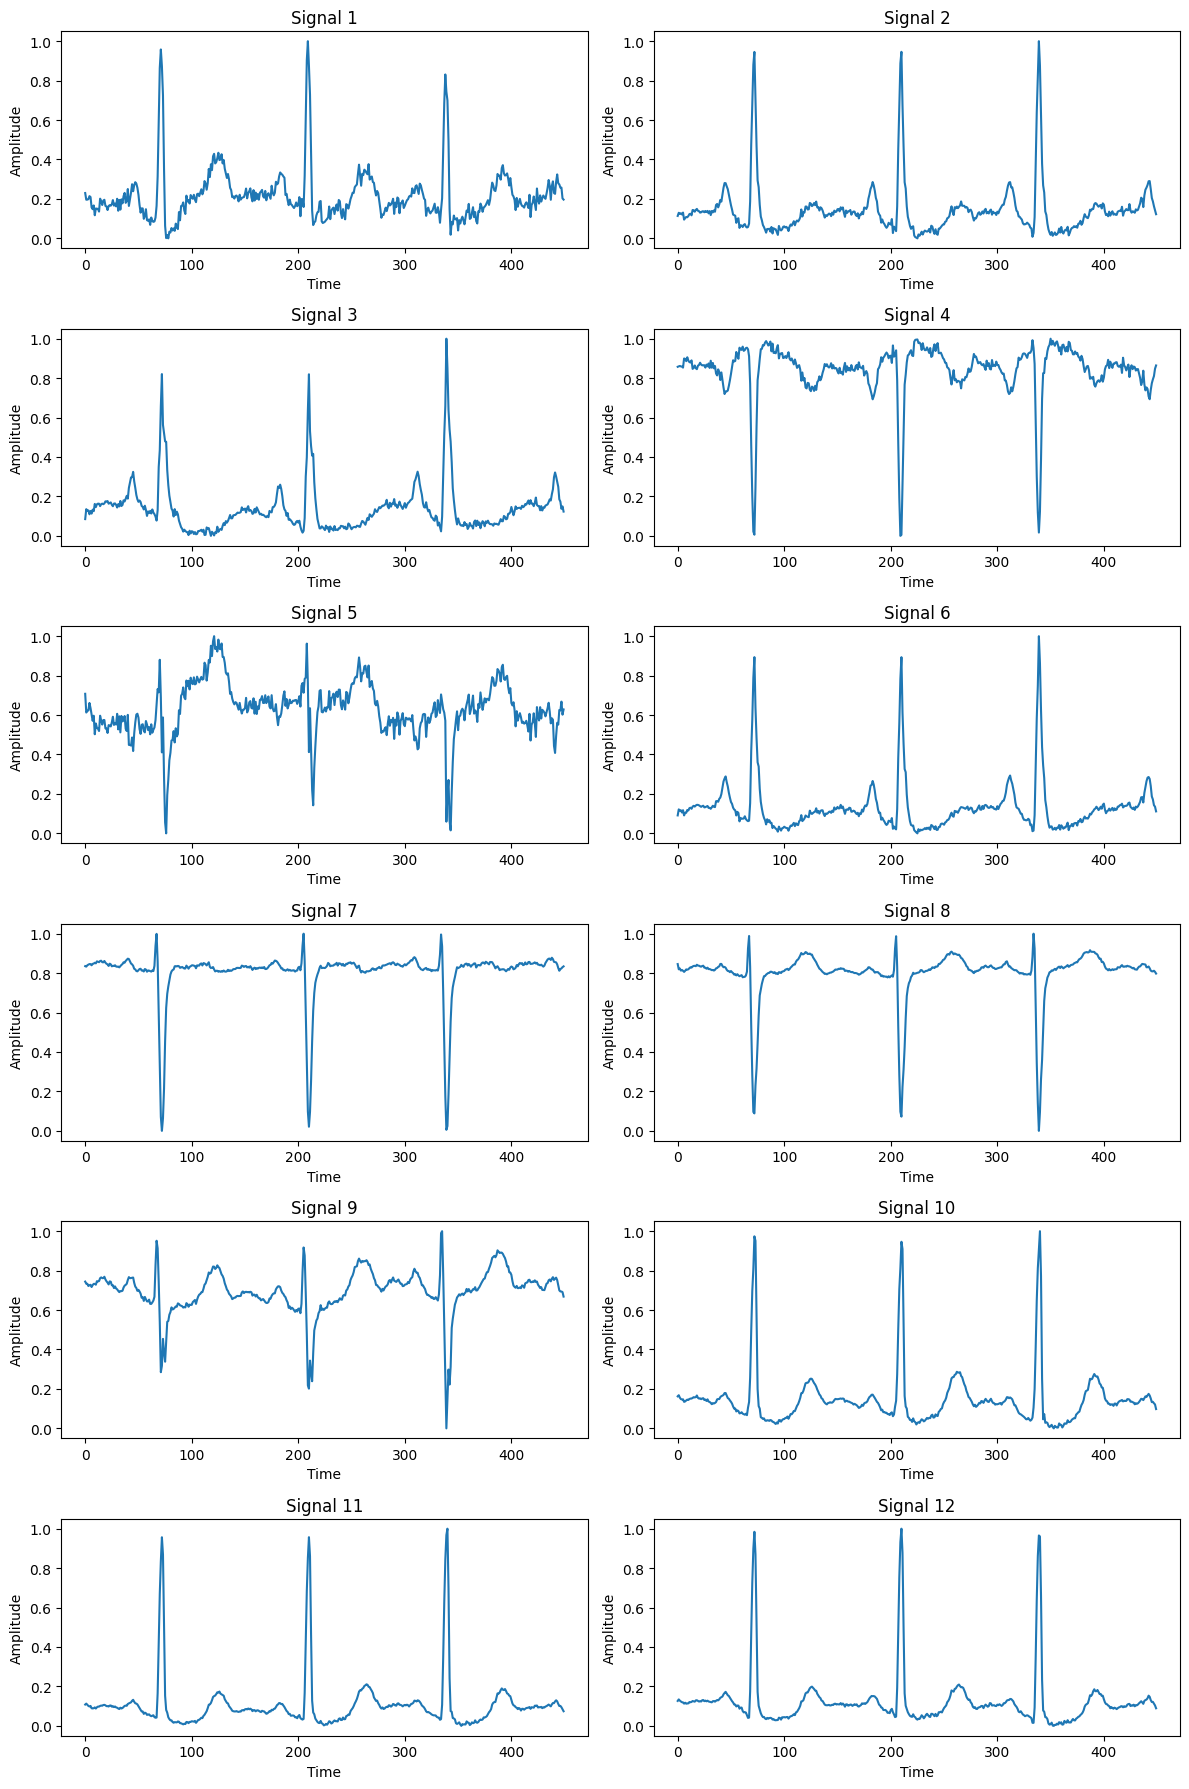

In [42]:
from upstream_seq2seq.utils.signal_processing import resample, normalize
segment.shape
plot_temp(segment)
plot_temp(np.squeeze(normalize(np.expand_dims(segment,0))))



In [57]:
# saving
data_path               = "./downstream_classification/data/china-raw/"
data_saving_folder_path = './downstream_classification/data/china-processed_divided_into_450/'
metadata_path           = './downstream_classification/data/combined_data/'
window = 450
stride = 100
AF_flag = '164889003'


samples = list({f.replace('.hea','').replace('.mat','') for f in os.listdir(data_path)})

results_df = {
    'filename':[],
    'index':[],
    'AF':[]
}

outer_index = 0
for sample in tqdm(samples):
    # init
    ind = 0
    start = 0

    # load data and label
    X, label = load_one_example(sample, data_path)
    af = 1 if '164889003' in label[0].split(',') else 0

    # process X
    X = np.expand_dims(X,0)
    X = resample(X, original_hz=500, desired_hz=200)
    L = X.shape[-1]

    while start + window <= L:
        segment = X[:,:, start:(start + window)]
        segment = normalize(segment) # normalize also squeezes funciton, so it is [1,12,:]->[12,:]

        temp_name = f'{sample}_{ind}'

        # save
        np.save(data_saving_folder_path + temp_name + '.npy', segment)

        # keep values
        results_df['filename'].append(temp_name)
        results_df['index'].append(outer_index)
        results_df['AF'].append(af)
        

        # update running inds
        start += stride
        ind += 1
        outer_index += 1

results_df = pd.DataFrame(results_df)
# results_df.to_csv(metadata_path + 'china.csv')
display(
    results_df['AF'].value_counts()
)
display(
    results_df['AF'].value_counts(normalize=True)
)

100%|██████████| 3453/3453 [01:52<00:00, 30.74it/s]


AF
0    91999
1     4049
Name: count, dtype: int64

AF
0    0.957844
1    0.042156
Name: proportion, dtype: float64

In [59]:
os.listdir(data_saving_folder_path)[:20]

['Q0077_2.npy',
 'Q1862_8.npy',
 'Q3357_8.npy',
 'Q3527_11.npy',
 'Q1130_5.npy',
 'Q2010_11.npy',
 'Q1009_10.npy',
 'Q0578_45.npy',
 'Q1464_37.npy',
 'Q0083_14.npy',
 'Q0423_55.npy',
 'Q0892_15.npy',
 'Q1758_10.npy',
 'Q1818_11.npy',
 'Q3246_5.npy',
 'Q2741_11.npy',
 'Q2801_10.npy',
 'Q3276_11.npy',
 'Q1021_8.npy',
 'Q0582_6.npy']

# Split

In [8]:
import random

data_path               = "./downstream_classification/data/china-raw/"
data_saving_folder_path = './downstream_classification/data/china-processed_divided_into_450/'
metadata_path           = './downstream_classification/data/combined_data/'
window = 450
stride = 100
AF_flag = '164889003'

results_df = pd.read_csv(metadata_path + 'china.csv',index_col=0)
results_df['reading'] = [x.split('_')[0] for x in results_df['filename']]

unique_readings = results_df['reading'].unique().tolist()
random.shuffle(unique_readings)

N_train = int(0.7*len(unique_readings))
N_validation = int(0.15*len(unique_readings))

train_sample = unique_readings[:N_train]
validation_sample = unique_readings[N_train:(N_train+N_validation)]
test_sample = unique_readings[(N_train+N_validation):]

print("train:",len(train_sample))
print("validation:",len(validation_sample))
print("test:",len(test_sample))

display(
    results_df[results_df['reading'].isin(train_sample)]['AF'].value_counts(normalize=True)
)
display(
    results_df[results_df['reading'].isin(validation_sample)]['AF'].value_counts(normalize=True)
)
display(
    results_df[results_df['reading'].isin(test_sample)]['AF'].value_counts(normalize=True)
)

results_df['sample'] = None
results_df['sample'][results_df['reading'].isin(train_sample)] = 'train'
results_df['sample'][results_df['reading'].isin(validation_sample)] = 'validation'
results_df['sample'][results_df['reading'].isin(test_sample)] = 'test'

display(results_df['sample'].value_counts())
display(results_df['sample'].value_counts(normalize=True))

# results_df.to_csv(metadata_path + 'china.csv')


train: 2417
validation: 517
test: 519


AF
0    0.95932
1    0.04068
Name: proportion, dtype: float64

AF
0    0.95508
1    0.04492
Name: proportion, dtype: float64

AF
0    0.953472
1    0.046528
Name: proportion, dtype: float64

/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_39607/997518350.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['sample'][results_df['reading'].isin(train_sample)] = 'train'
/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_39607/997518350.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['sample'][results_df['reading'].isin(validation_sample)] = 'validation'
/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_39607/997518350.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

sample
train         68043
test          14314
validation    13691
Name: count, dtype: int64

sample
train         0.708427
test          0.149030
validation    0.142543
Name: proportion, dtype: float64

In [12]:
# results_df.rename({'reading':'original_file', 'filename':'reading'},axis=1).to_csv(metadata_path + 'china.csv')